<a href="https://colab.research.google.com/github/AilingLiu/From-Business-Insights-to-Action/blob/master/Customer_Segmentation_By_RFM_in_KMeans_Clustoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use Clustering Methods to segment customer groups, by first indexing RFM, then using K Means Clustering.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

# Get the data

In [5]:
url = 'https://github.com/AilingLiu/Growth_Analysis/blob/master/Data/online_retail.csv?raw=true'

data = pd.read_csv(url, sep=',', parse_dates=['InvoiceDate'], encoding='latin-1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Clean up data

In [46]:
# clean up the negative quantity and unit price
df = data.loc[(data['Quantity'] >=0)&(data['UnitPrice']>=0), :]

# clean up rows where customerid is unknown
mask =df['CustomerID'].isnull() 
df = df.loc[~mask, :]

# get only the uk data
df = df[df['Country']=='United Kingdom']

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      354345 non-null object
StockCode      354345 non-null object
Description    354345 non-null object
Quantity       354345 non-null int64
InvoiceDate    354345 non-null datetime64[ns]
UnitPrice      354345 non-null float64
CustomerID     354345 non-null float64
Country        354345 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB


## Grouping based on RFM

In [106]:
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']

gb=df.groupby(['CustomerID']).agg(
    Last_Order_Date=('InvoiceDate', 'max'),
    Total_Orders=('InvoiceNo', 'nunique'),
    Total_Revenue=('TotalPrice', 'sum'))

m = gb['Last_Order_Date'].max().normalize()

diff = lambda x: (m-x.normalize()).days
gb['Recency'] = gb['Last_Order_Date'].transform(diff)
#gb['Total_Revenue(k)'] = (gb['Total_Revenue']/1000).round(2) 
#gb = gb.drop(columns=['Last_Order_Date', 'Total_Revenue'])
gb = gb.drop(columns=['Last_Order_Date'])

gb.head()

,Total_Orders,Total_Revenue,Recency
CustomerID,,,
12346.0,1,77183.60,325
12747.0,11,4196.01,2
12748.0,210,33719.73,0
12749.0,5,4090.88,3
12820.0,4,942.34,3


# K Means Clustering (Total revenue)

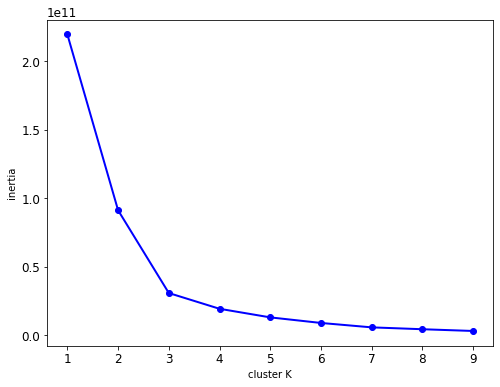

In [108]:
from sklearn.cluster import KMeans

revenue = gb[['Total_Revenue']]
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(revenue) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), inertias, 'bo-', linewidth=2)
plt.xlabel('cluster K')
plt.ylabel('inertia');
#plt.axis([1, 8, 0, 55])

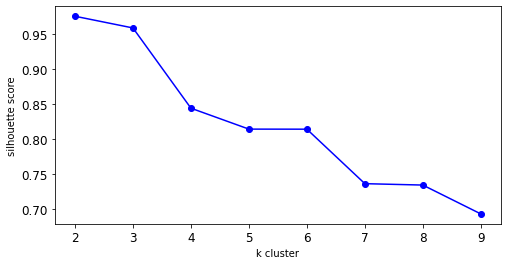

In [110]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(revenue, model.labels_) for model in kmeans_per_k[1:]]
plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, 'bo-')
plt.xlabel('k cluster')
plt.ylabel('silhouette score')
plt.xticks(range(2, 10));

# K Means Clustering (exploring new methods)

In [0]:
from sklearn.cluster import KMeans
k=5 #let's make 5 groups 
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(gb)

In [49]:
# The center of each classes
kmeans.cluster_centers_.round(3)

array([[  6.498,  17.925,   3.019],
       [  1.462, 247.876,   0.557],
       [  2.113, 161.004,   0.712],
       [  1.377, 336.306,   0.661],
       [  2.741,  73.063,   0.996]])

## inertia


Inertia is the sum of the squared distances between each training instance and its closest centroid.

In [50]:
# inertia the smaller the better
kmeans.inertia_

1757311.4780574543

## choosing optimal k clusters

In [0]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(gb) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

(1.0, 8.0, 0.0, 55.0)

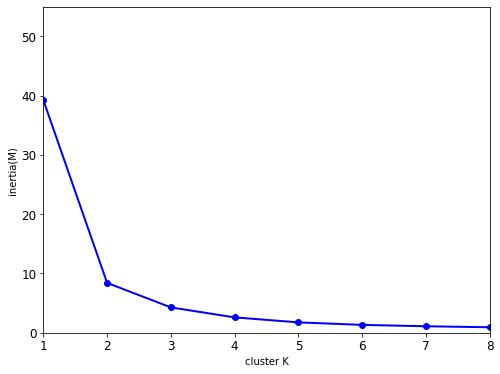

In [52]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), np.array(inertias)/1000000, 'bo-', linewidth=2)
plt.xlabel('cluster K')
plt.ylabel('inertia(M)')
plt.axis([1, 8, 0, 55])

Using the the raw RFM value, the clusters have the optimal inertias at 2 clusters. With only two clusters are not likely help to identify customers group characteristics. This time, we give each RFM a score according to quantile.

In [0]:
gb['RecencyScore'] = pd.qcut(gb['Recency'], 4, labels=[1,2,3,4])
gb['FrequencyScore'] = pd.qcut(gb['Total_Orders'], [0, .5, .75, .95, 1], labels=[4,3,2,1])
gb['RevenueScore'] = pd.qcut(gb['Total_Revenue(k)'], 4, labels=[4,3,2,1])

In [0]:
X = gb[['RecencyScore', 'FrequencyScore',  'RevenueScore']]
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 20)]
inertias = [model.inertia_ for model in kmeans_per_k]

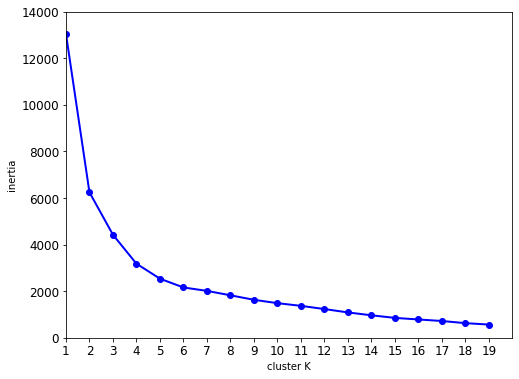

In [79]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), inertias, 'bo-', linewidth=2)
plt.xlabel('cluster K')
plt.ylabel('inertia')
plt.axis([1, 20, 0, 14000])
plt.xticks(range(1, 20));

Based on above elbow shape, we consider to use k=4 or k=5. The slop of inertia starts to become much smaller than k=5.

## silhouette score


Another method is to use silhouette score to measure the ratio of average instance within cluster and average distance between other clusters.

In [80]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]
silhouette_scores

[0.4498582603719513,
 0.42073034083636635,
 0.44242884124951604,
 0.4491898389541371,
 0.44964880378583916,
 0.43911126971147046,
 0.4566308160643437,
 0.5194784965246436,
 0.5550022501998936,
 0.5175919167609895,
 0.5471482157562271,
 0.5945606624982722,
 0.6337442185861201,
 0.6541287985906267,
 0.6760428854663296,
 0.698790339496513,
 0.730355412101882,
 0.7505014892952322]

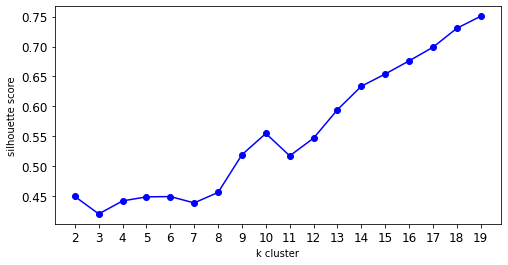

In [84]:
plt.figure(figsize=(8, 4))
plt.plot(range(2, 20), silhouette_scores, 'bo-')
plt.xlabel('k cluster')
plt.ylabel('silhouette score')
plt.xticks(range(2, 20));

At cluster 10, we have a peak score.

## sihouette diagram

This is the best way to visualize clusters. It shows the total sample size in each cluster, and sihouette scores as well.

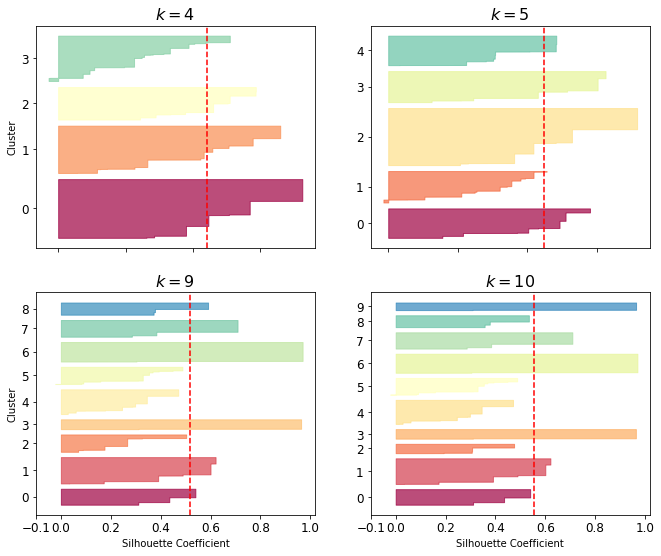

In [89]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for a, k in enumerate([4, 5, 9, 10]):
    plt.subplot(2, 2, a+1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (4, 9):
        plt.ylabel("Cluster")
    
    if k in (9, 10):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()

when cluster k=4, each cluster's sample size is more equal than k=5.

## giving 6 index to each rfm

In [0]:
gb['Recency6Score'] = pd.qcut(gb['Recency'], 6, labels=list(range(1, 7)))
gb['Frequency6Score'] = pd.qcut(gb['Total_Orders'], [0, 0.5, 0.6, 0.7, 0.8, 0.9, 1], labels=list(range(6, 0, -1)))
gb['Revenue6Score'] = pd.qcut(gb['Total_Revenue(k)'], [0, 0.5, 0.6, 0.7, 0.8, 0.9, 1], labels=list(range(6, 0, -1)))

In [0]:
X = gb[['Recency6Score', 'Frequency6Score',  'Revenue6Score']]
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 20)]
inertias = [model.inertia_ for model in kmeans_per_k]

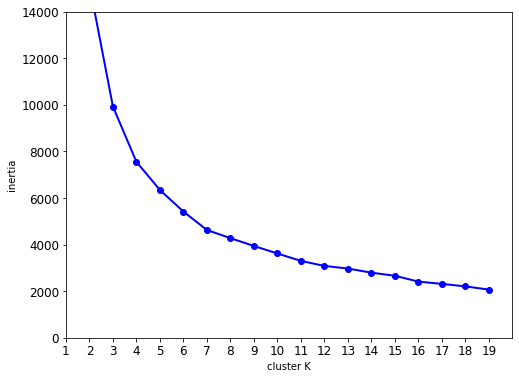

In [104]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), inertias, 'bo-', linewidth=2)
plt.xlabel('cluster K')
plt.ylabel('inertia')
plt.axis([1, 20, 0, 14000])
plt.xticks(range(1, 20));

Giving the score to each RFM and then cluster customer based on these scores doesn't give a good indication of elbow joint. By giving 6 indexes of each rfm, the inertia decreased compared to the inertia from 4 indexs.

We can consider to use clustering directly to give index on each rfm metric, and then use the composite score to match customers into category.